Network Built: 154 Nodes, 4046 Edges

Top 10 Most Central Actors (Hubs):
                                                Actor       Category  \
9                    Canada Foundation for Innovation     Government   
21                              Global Affairs Canada     Government   
4                 Business Development Bank of Canada     Government   
83  Innovation, Science and Economic Development C...     Government   
68                                             D-Wave       Industry   
67                           Creative Destruction Lab  Civil Society   
70                                               DRDC     Government   
71            Defence Research and Development Canada     Government   
72                     Department of National Defence     Government   
69                                                DND     Government   

    Degree_Centrality  Betweenness_Centrality  
9            0.764706                0.235681  
21           0.764706                0

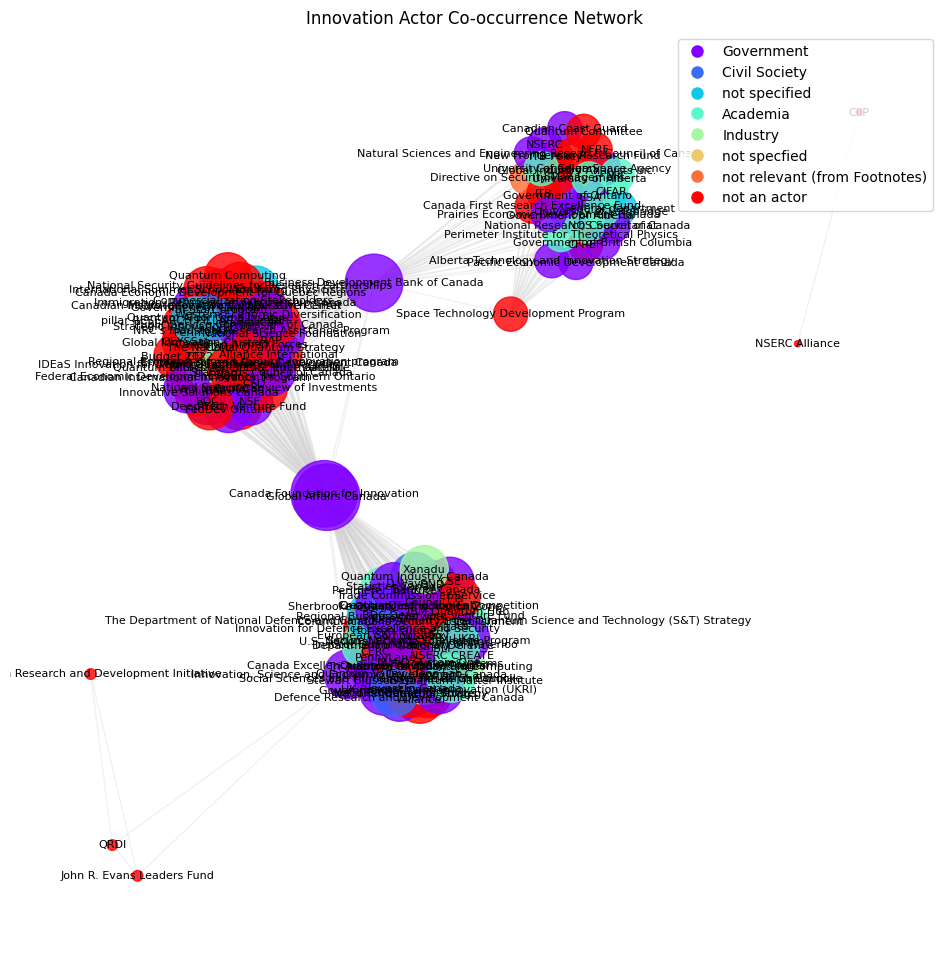

In [11]:
# Cell 7: Network Visualization and Analysis
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import pandas as pd

# Load data
df = pd.read_csv("entities_ready_for_network.csv")

# Initialize Graph
G = nx.Graph()

# --- A. Build Edges (Co-occurrence in Block) ---
# Group by Document and Block (Paragraph level co-occurrence)
grouped = df.groupby(['Doc_ID', 'Block_ID'])['Label'].apply(list)

edge_list = []
for actors in grouped:
    # We need at least 2 actors to form a link
    if len(actors) > 1:
        # Sort to ensure (A,B) is same as (B,A)
        for u, v in combinations(sorted(actors), 2):
            edge_list.append((u, v))

# Add edges with weights (frequency of co-occurrence)
for u, v in edge_list:
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u, v, weight=1)

# Add Node Attributes (Category)
# Create a mapping of Label -> Category
cat_map = df.set_index('Label')['qh_category'].to_dict()
nx.set_node_attributes(G, cat_map, name="category")

print(f"Network Built: {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges")

# --- B. Calculate Centrality (Emphasis) ---
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)

# Create a DataFrame for Analysis
ranking = pd.DataFrame({
    'Actor': list(G.nodes()),
    'Category': [G.nodes[n]['category'] for n in G.nodes()],
    'Degree_Centrality': [degree_cent[n] for n in G.nodes()],
    'Betweenness_Centrality': [betweenness_cent[n] for n in G.nodes()]
}).sort_values(by='Degree_Centrality', ascending=False)

print("\nTop 10 Most Central Actors (Hubs):")
print(ranking.head(10))
ranking.to_csv("rq2_network_stats.csv", index=False)

# --- C. Visualization (Static) ---
plt.figure(figsize=(12, 12))

# Layout algorithm (Spring usually works best for social networks)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

# Color mapping for categories
categories = list(set(cat_map.values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
color_map = {cat: col for cat, col in zip(categories, colors)}
node_colors = [color_map.get(G.nodes[n]['category'], 'grey') for n in G.nodes()]

# Draw
nx.draw_networkx_nodes(G, pos, node_size=[v * 3000 for v in degree_cent.values()], node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='lightgrey')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cat,
                          markerfacecolor=col, markersize=10) for cat, col in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.title("Innovation Actor Co-occurrence Network")
plt.axis('off')
plt.show()

Loading data...
Scanning 362 paragraphs for sentence-level interactions...


C:\Users\user\AppData\Local\Temp\ipykernel_22980\210567244.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  block_map = df_ent.groupby(['Doc_ID', 'Block_ID']).apply(


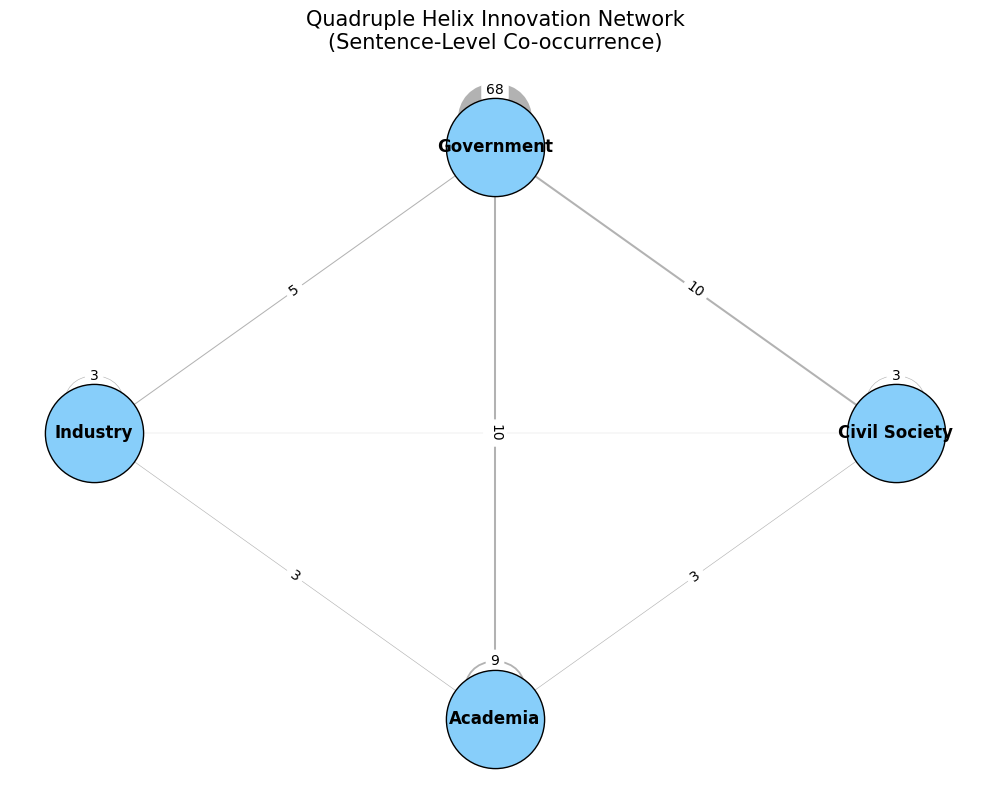

✅ Graph generated!


In [19]:
import pandas as pd
import re
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
TARGETS = ["Civil Society", "Government", "Industry", "Academia"]
text_csv = "text_countries_edited.csv"
entities_csv = "entities_to_edit.csv"

# --- 2. LOAD & FILTER DATA ---
print("Loading data...")
df_text = pd.read_csv(text_csv).fillna("")
df_ent = pd.read_csv(entities_csv).fillna("")

# Normalize & Filter for the 4 Helices
df_ent['qh_category'] = df_ent['qh_category'].astype(str).str.strip()
df_ent = df_ent[df_ent['qh_category'].isin(TARGETS)]

# Create quick lookup: (Doc_ID, Block_ID) -> List of [(Name, Category)]
# This speeds up the search significantly
block_map = df_ent.groupby(['Doc_ID', 'Block_ID']).apply(
    lambda x: list(zip(x['entity_name'].astype(str), x['qh_category']))
).to_dict()

# --- 3. BUILD NETWORK ---
G = nx.Graph()
G.add_nodes_from(TARGETS) # Ensure all 4 nodes exist even if disconnected

print(f"Scanning {len(df_text)} paragraphs for sentence-level interactions...")

for _, row in df_text.iterrows():
    # Retrieve entities for this specific paragraph
    ents = block_map.get((row['Doc_ID'], row['Block_ID']), [])
    if len(ents) < 2: continue

    # Split paragraph into sentences (Regex: Split on .?! followed by Capital Letter)
    sentences = [s.strip() for s in re.split(r'(?<=[.!?])\s+(?=[A-Z])', str(row['text'])) if s.strip()]

    for sent in sentences:
        # Identify which categories appear in this specific sentence
        # (Case-insensitive match of Entity Name in Sentence Text)
        found_cats = [cat for name, cat in ents if name.lower() in sent.lower()]
        
        # Add links for every pair found in the same sentence
        for c1, c2 in itertools.combinations(sorted(found_cats), 2):
            if G.has_edge(c1, c2):
                G[c1][c2]['weight'] += 1
            else:
                G.add_edge(c1, c2, weight=1)

# --- 4. VISUALIZE NETWORK GRAPH ---
plt.figure(figsize=(10, 8))

# Layout: Circular is best for "Helix" concepts
pos = nx.circular_layout(G)

# Extract weights for sizing
edges = G.edges(data=True)
weights = [data['weight'] for u, v, data in edges]
max_weight = max(weights) if weights else 1

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='#87CEFA', edgecolors='black')

# Draw Edges (Thickness based on weight)
# We scale the width: thickest line = 10px
nx.draw_networkx_edges(G, pos, width=[(w / max_weight) * 10 for w in weights], alpha=0.6, edge_color='gray')

# Draw Labels (Interaction Counts on edges + Node Names)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Quadruple Helix Innovation Network\n(Sentence-Level Co-occurrence)", fontsize=15)
plt.axis('off')
plt.tight_layout()

# Save and Show
plt.savefig("qh_network_graph.png")
plt.show()

print("✅ Graph generated!")